# CTC based ASR

In this seminar we will do the following things:

    - Write data processing to train a speech recognition model
    - Write a simple model
    - Train the model using the CTC loss function 
    - Measure the quality using metrics like CER

In [48]:
from IPython import display
from matplotlib import pyplot as plt
from collections import defaultdict

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset

import torchaudio
from torchaudio.transforms import MelSpectrogram

assert torch.__version__.startswith('1.8')
assert torchaudio.__version__.startswith('0.8')

In [21]:
def visualize_audio(wav: torch.Tensor, sr: int = 22050):
    if wav.dim() == 2:
        wav = wav.mean(dim=0)
    
    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()
    
    display.display(display.Audio(wav, rate=sr, normalize=False))

# Data

This is a dataset with numbers from 0 to 999_999 pronounced in Russian.
There are different speakers of different ages and genders

In [7]:
!wget https://raw.githubusercontent.com/markovka17/apdl/master/gfile.py

--2021-04-20 16:22:59--  https://raw.githubusercontent.com/markovka17/apdl/master/gfile.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3423 (3,3K) [text/plain]
Saving to: ‘gfile.py’

gfile.py            100%[===================>]   3,34K  --.-KB/s    in 0s      

2021-04-20 16:23:00 (19,2 MB/s) - ‘gfile.py’ saved [3423/3423]



In [9]:
!mkdir data
!python gfile.py -u https://drive.google.com/file/d/1HKtLLbiEk0c3l1mKz9LUXRAmKd3DvD0P \
    -f "numbers.zip" \
    -d data/

!unzip data/numbers.zip -d data/

Convert all audio to the same sample_rate=16000, and convert the answers to the form we want. For example, if the number 123 is pronounced, then the answer is: y = [1,2,3].

Let's implement all these stuff in `SpeechDataset` class. This class should have constructor (\_\_init\_\_ method), \_\_getitem\_\_ and \_\_len\_\_.

In [13]:
import os

import pandas as pd
import numpy as np


class SpeechDataset(Dataset):
    
    SAMPLE_RATE = 16000
    _ROOT_PREFIX = 'data/numbers'

    def __init__(self, path_to_csv: str):
        self.path_to_csv = path_to_csv

        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)

    @staticmethod
    def number2digits(number: np.ndarray) -> torch.Tensor:
        digits = list(map(int, list(str(number))))
        return torch.LongTensor(digits)

    def __getitem__(self, index: int):
        output = self.csv.iloc[index]
        
        if len(output) == 3:
            path, gender, number = output
            y = self.number2digits(number)
        else:
            path, = output
            y = torch.LongTensor([-1])

        path = os.path.join(self._ROOT_PREFIX, path)

        wav, sr = torchaudio.load(path)
        if sr != self.SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(sr, self.SAMPLE_RATE)
            wav = resampler(wav)
        
        wav = wav.squeeze()

        instance = {
            'path': path,
            'x': wav,
            'y': y
        }

        return instance

    def __len__(self):
        return self.csv.shape[0]

Randomly split dataset on `train` and `validation`.

In [17]:
dataset = SpeechDataset('data/numbers/train.csv')

train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)
random_indexes = torch.randperm(len(dataset)).tolist()

train_dataset = Subset(dataset, random_indexes[:train_size])
val_dataset = Subset(dataset, random_indexes[train_size:])

In [18]:
len(train_dataset), len(val_dataset)

(8100, 900)

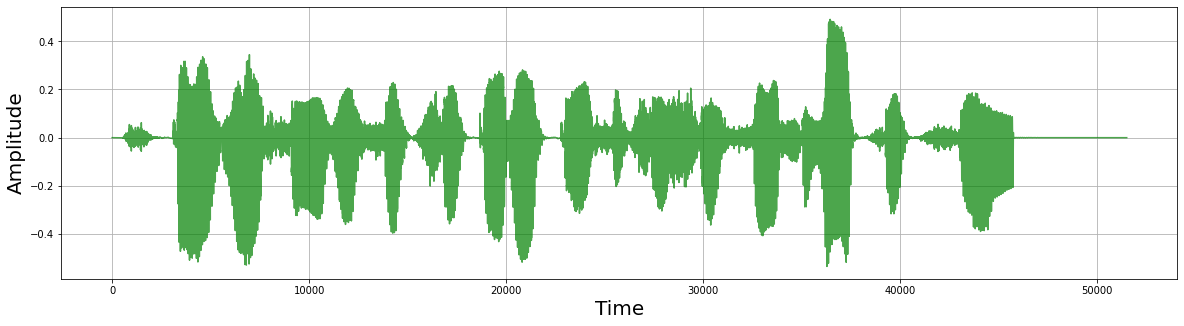

In [22]:
instance = train_dataset[0]
visualize_audio(instance['x'], dataset.SAMPLE_RATE)

In [24]:
instance['y']

tensor([1, 8, 4, 6, 2, 7])

Let's introduce padding. Dataset contains numbers from 0 to 999999. To work with the dataset, it is convenient for us that all the answers y be of the same length. If the number is shorter than six digits, we fill the remaining cells with '10':

    123456 -> y = [1, 2, 3, 4, 5, 6]

    123    -> y = [1, 2, 3, 10, 10, 10]

In [25]:
from tqdm import tqdm
from itertools import islice


class PaddingCollator:

    def __call__(self, instances):
        
        batch_size = len(instances)
        x_len = torch.LongTensor([instance['x'].size(0) for instance in instances])
        y_len = torch.LongTensor([instance['y'].size(0) for instance in instances])
        path = [instance['path'] for instance in instances]

        x = torch.zeros(batch_size, max(x_len), dtype=torch.float32)
        y = torch.zeros(batch_size, max(y_len), dtype=torch.long)
        y.fill_(10)  # 10 -- padding

        for i, instance in enumerate(instances):
            x[i, :x_len[i]] = instance['x']
            y[i, :y_len[i]] = instance['y']

        instance = {
            'x': x,
            'y': y,
            'x_len': x_len,
            'y_len': y_len,
            'path': path
        }
        
        return instance

In [27]:
train_dataloader = DataLoader(
    train_dataset, 64,
    collate_fn=PaddingCollator(), shuffle=True,
#     pin_memory=True, num_workers=2
)
val_dataloader = DataLoader(
    val_dataset, 32, collate_fn=PaddingCollator(),
#     pin_memory=True, num_workers=2
)

Let's see what we have in our batch

In [32]:
batch = list(islice(val_dataloader, 1))[0]
batch['x'][:2, :]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [33]:
batch['y'][:2, :]

tensor([[2, 7, 3, 1, 8, 9],
        [1, 4, 2, 0, 2, 3]])

In [34]:
batch.keys()

dict_keys(['x', 'y', 'x_len', 'y_len', 'path'])

# Feature Extraction

Example of obtaining a (mel) spectrogram from a signal: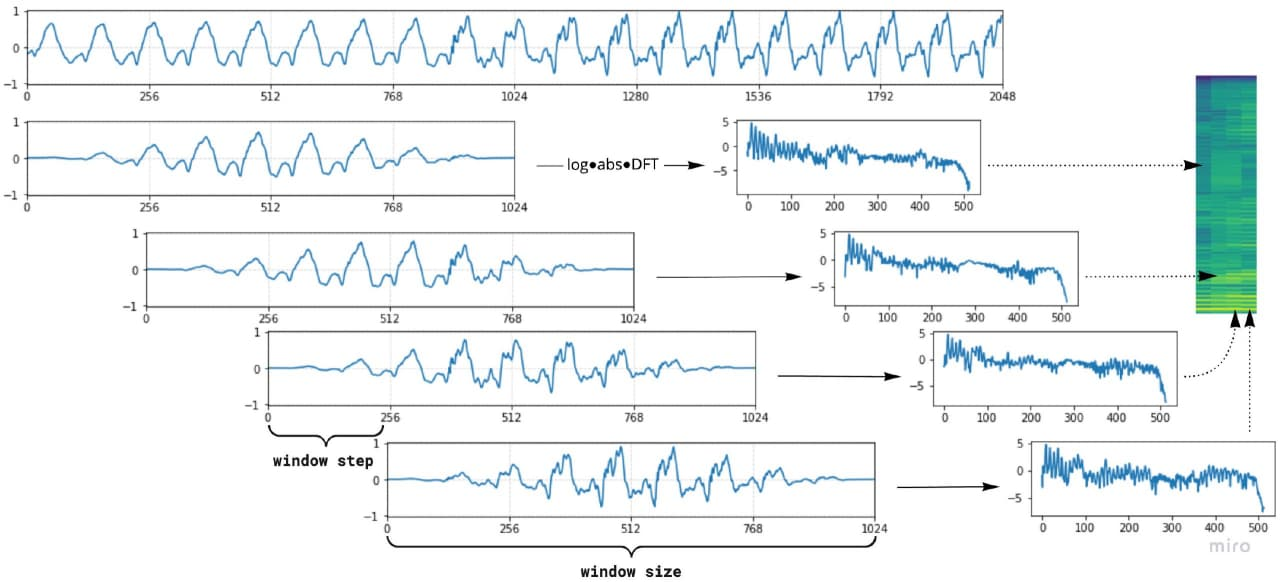

In [38]:
def apply_compression(melspec):
    # Add eps=1e-7 to avoid log(0)
    return torch.log(melspec.clamp(1e-5))

In [40]:
class Featurizer(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.featurizer = MelSpectrogram(
            sample_rate=train_dataset.dataset.SAMPLE_RATE,
            n_fft=1024,
            win_length=1024,
            hop_length=256,
            n_mels=64,
            power=1
        )
    
    def forward(self, x, x_len=None):
        x = self.featurizer(x)
        x = apply_compression(x)
        
        # Convert the length from wav dimension to spectrogram dimension
        if x_len is not None:
            x_len = ((x_len + 1).float() / self.featurizer.hop_length).ceil().long()
            return x, x_len
        
        return x

## Model

Let's write a simple and small model based on QuartzNet https://arxiv.org/pdf/1910.10261.pdf

In [41]:
from torch import nn


class QuartzBlock(nn.Module):
    """
    Basic block of QuartzNet consisting of Separable Convolution, BatchNorm and ReLU repeating R times
    
    :param in_channels: number of input channels
    :param hidden_channels: number of hidden and output channels
    :param kernel_size: size of kernels
    :param repeat: number of repetitions of block constituents
    """
    
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        kernel_size: int = 33,
        repeat: int = 4,
    ):
        super().__init__()
        
        self.repeat = repeat
        self.blocks = nn.ModuleList([
            nn.ModuleList([
                nn.Conv1d(
                    in_channels=in_channels if i == 0 else hidden_channels,
                    out_channels=hidden_channels,
                    kernel_size=kernel_size,
                    groups=in_channels if i == 0 else hidden_channels,
                    padding=kernel_size // 2
                ),
                nn.Conv1d(hidden_channels, hidden_channels, kernel_size=1),
                nn.BatchNorm1d(hidden_channels),
                nn.ReLU(),
            ])
            for i in range(repeat)
        ])
        self.res_conv = nn.Sequential(  # convolution for residual
            nn.Conv1d(in_channels, hidden_channels, kernel_size=1),
            nn.BatchNorm1d(hidden_channels),
        )

    def forward(self, x):
        x_initial = x
        
        for i, block in enumerate(self.blocks):
            for j, layer in enumerate(block):
                # If not last ReLU
                if not (i == (len(self.blocks) - 1) and j ==( len(block) - 1)):
                    x = layer(x)
                else:
                    # Pass residual
                    x = x + self.res_conv(x_initial)
                    x = layer(x)
        return x



In [42]:
class DummyModel(nn.Module):

    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        self.prenet = nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, 33, padding=33 // 2, stride=2),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU()
        )
        
        self.net = nn.Sequential(
            QuartzBlock(hidden_channels, hidden_channels),
            QuartzBlock(hidden_channels, hidden_channels * 2),

            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, 33,
                      padding=33 // 2, stride=2),
            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(),

            QuartzBlock(hidden_channels * 2, hidden_channels * 4)
        )
        self.classifier = nn.Sequential(
            nn.Conv1d(hidden_channels * 4, out_channels, kernel_size=1),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x, x_len):
        x = self.prenet(x)
        x = self.net(x)
        return self.classifier(x), x_len // 4

# DummyModel(64, 128, 10 + 1)

## Calculate CER (character error rate)

An example of calculating a similar metric, but by words (WER, word error rate): https://www.rev.ai/blog/how-to-calculate-word-error-rate/

In [45]:
!pip install Levenshtein

Just a way to decode the predictions when we train model with `CTC` criterion is to collapse the repeating characters and remove the `blank` characters:

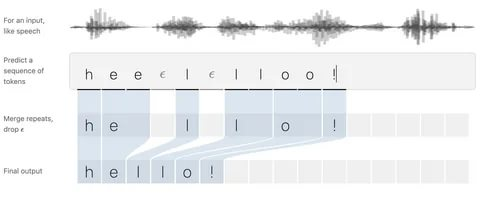

In [46]:
import Levenshtein


def ctc_decode(sequence, black_symbol=10):
    """
    Decode hypotheses
        1) Remove repetitive letters
        2) Remove blank characters
    """
    
    current = []
    for i in range(0, len(sequence)):
        symbol = sequence[i]

        if i > 0 and symbol == sequence[i - 1]:
            continue

        # skip blank symbol
        if symbol == black_symbol:
            continue

        current.append(str(int(symbol)))

    text = ''.join(current)
    return text


def calculate_cer(targets, decodings, padding_value=10):
    """
    Calculate the Levenshtein distance between predictions and GT
    """
    
    cer = 0.0
    targets = targets.detach().cpu().tolist()

    pairs = []
    for target, d in zip(targets, decodings):
        target = [c for c in target if c != padding_value]
        target = "".join(map(str, target))

        decoding = ctc_decode(d.tolist())
        cer += min(1, Levenshtein.distance(target, decoding) / (len(decoding) + 1e-7))

        pairs.append(
            target + '\t\t' + decoding
        )

    return cer / len(target), pairs

## Training

In [47]:
class AverageMeter:
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
NUM_EPOCH = 20
DEVICE = torch.device('cuda:0')

model = DummyModel(64, 128, 10 + 1).to(DEVICE)
mel_featurizer = Featurizer().to(DEVICE)
criterion = nn.CTCLoss(blank=10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

In [ ]:
history = defaultdict(list)

Epoch: 19
Example of prediction:  421001 -> 421001959198131
Example of prediction:  378376 -> 3783765
Example of prediction:  528450 -> 528450895481
Example of prediction:  893448 -> 8934483549
Example of prediction:  653402 -> 653402543651


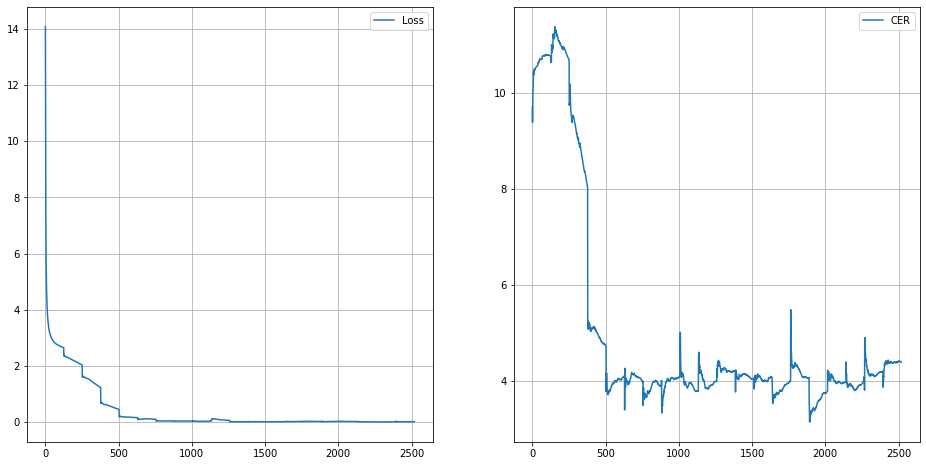

In [ ]:
for epoch in range(NUM_EPOCH):

    average_cer = AverageMeter()
    average_loss = AverageMeter()
    
    for batch in train_dataloader:
        x = batch['x'].to(DEVICE)
        y = batch['y'].to(DEVICE)
        x_len = batch['x_len'].to(DEVICE)
        y_len = batch['y_len'].to(DEVICE)
        
        x, x_len = mel_featurizer(x, x_len)
        
        log_probs, x_len = model(x, x_len)
        
        # B, C, T -> T, B, C
        log_probs = log_probs.permute(2, 0, 1)
        loss = criterion(log_probs, y, x_len, y_len)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # T, B, C -> T, B -> B, T
        argmax_decoding = log_probs.detach().cpu() \
            .argmax(dim=-1).transpose(0, 1)

        cer, pairs = calculate_cer(y, argmax_decoding)

        average_cer.update(cer)
        average_loss.update(loss.item())

        history['loss'].append(average_loss.avg)
        history['cer'].append(average_cer.avg)
    
    display.clear_output()
    print(f'Epoch: {epoch}')
    for i in range(5):
        print(f'Example of prediction: ', pairs[i].replace("\t\t", " -> "))
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].plot(history['loss'], label='Loss')
    axes[1].plot(history['cer'], label='CER')
    axes[0].legend(); axes[0].grid()
    axes[1].legend(); axes[1].grid()
    plt.show()

## What's next?

    1) Add some augmentations from previous seminar

    2) Improve the model. For example, reduce the time space even more. Now we reduce it 4 times, but it is still not enough since the length of GT string is 4-6.
    3) Translate numbers into letters and train letter recognition model (overkill :))
    4) Add a special symbol to separate the digits -- thousands/hundreds
    5) Stack more layers :)